In [59]:
import pygplates
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd

import paleogeography as pg
from pigplates import sphere_tools as pigsph

%matplotlib inline


reconstruction_basedir = '../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'
rotation_model = pygplates.RotationModel('%s/Global_EarthByte_230-0Ma_GK07_AREPS.rot' % reconstruction_basedir)

static_polygons = pygplates.FeatureCollection('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/ContinentalPolygons/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz')


def reconstruct_dataframe(df,static_polygons,rotation_model,reconstruction_time):
    
    point_features = []
    # put the points into a feature collection, using Lat,Long coordinates from dataframe
    for index,row in df.iterrows():
        point = pygplates.PointOnSphere(float(row.lat),float(row.lng))
        point_feature = pygplates.Feature()
        point_feature.set_geometry(point)
        point_features.append(point_feature)

    # The partition points function can then be used as before
    partitioned_point_features = pygplates.partition_into_plates(static_polygons,
                                                                 rotation_model,
                                                                 point_features) 
    
    reconstructed_point_features = []
    pygplates.reconstruct(partitioned_point_features,rotation_model,
                          reconstructed_point_features,reconstruction_time)
    
    rlat = []
    rlon = []
    for point in reconstructed_point_features:
        rlat.append(point.get_reconstructed_geometry().to_lat_lon()[0])
        rlon.append(point.get_reconstructed_geometry().to_lat_lon()[1])
    
    return rlat,rlon
    
    

In [60]:
pbdb = pd.read_csv('/Users/Simon/Data/pbdb/pbdb_occs.csv',delimiter=',',skiprows=14)

print 'Total records read = %s' % pbdb.size

pbdb = pbdb.dropna(subset=['environment','lat','lng'])
print 'Total records with valid environment = %s' % pbdb.size

print pbdb.columns

print pbdb.environment.unique()


Total records read = 97112015
Total records with valid environment = 91071981
Index([u'occurrence_no', u'record_type', u'reid_no', u'superceded',
       u'collection_no', u'taxon_name', u'taxon_rank', u'taxon_no',
       u'matched_name', u'matched_rank', u'matched_no', u'early_interval',
       u'late_interval', u'early_age', u'late_age', u'reference_no', u'lng',
       u'lat', u'cc', u'state', u'county', u'geogscale', u'protected',
       u'early_age.1', u'late_age.1', u'cx_int_no', u'early_int_no',
       u'late_int_no', u'formation', u'stratgroup', u'member', u'stratscale',
       u'zone', u'localsection', u'localbed', u'localorder',
       u'regionalsection', u'regionalbed', u'regionalorder', u'stratcomments',
       u'lithdescript', u'lithology1', u'lithadj1', u'lithification1',
       u'minor_lithology1', u'fossilsfrom1', u'lithology2', u'lithadj2',
       u'lithification2', u'minor_lithology2', u'fossilsfrom2', u'environment',
       u'tectonic_setting', u'geology_comments', u'c

In [73]:
#comparison_time = 22.
from sklearn.neighbors import KernelDensity

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


def indicator_z_distribution(comparison_time,environment_search_string):

    # Add time range specifier
    #pbdb_subset = pbdb[(pbdb.early_age<(comparison_time+10.)) & (pbdb.late_age>(comparison_time-10.))]
    pbdb_subset = pbdb[(pbdb.early_age>comparison_time) & (pbdb.late_age<comparison_time)
                      & (pbdb.lat>=-90.) & (pbdb.lat<=90.) & (pbdb.lng>=-180.) & (pbdb.lng<=180)]
    pbdb_subset2 = pbdb_subset[pbdb_subset.environment.str.contains(environment_search_string)]
    print 'Time %d Ma | %s valid records | %s records with selected environment' % (comparison_time,
                                                                                    pbdb_subset.size,
                                                                                    pbdb_subset2.size)

    rla,rlo = reconstruct_dataframe(pbdb_subset2,static_polygons,rotation_model,comparison_time)

    # interpolate heights at grid
    grdfile = '../paleotopography/paleotopo_grids/paleotopobathy_smooth_%0.2fMa.nc' % comparison_time

    topo_smoothX,topo_smoothY,topo_smoothZ = pg.load_netcdf(grdfile)

    topo_smoothXg, topo_smoothYg = np.meshgrid(topo_smoothX,topo_smoothY)
    d,l = pigsph.sampleOnSphere(topo_smoothXg.flatten(),
                                topo_smoothYg.flatten(), 
                                topo_smoothZ.flatten(),
                                np.array(rlo),
                                np.array(rla),
                                k=4)


    # based on http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    w = 1./d**2
    pbdb_topo = np.sum(w * topo_smoothZ.flatten().ravel()[l],axis=1) / np.sum(w,axis=1)

    age_range = np.array(pbdb_subset2.early_age - pbdb_subset2.late_age)

    #h,be = np.histogram(pbdb_topo,bins=40,range=(-1000,1000),weights=1./age_range)
    #bc = (be[:-1] + be[1:]) / 2
    bc=np.arange(-1000,1000,50)
    h = kde_sklearn(pbdb_topo,bc,bandwidth=100)

    # normalise so that histogram bin counts always sum to 1
    #h = h/np.sum(h)
        
    return bc,h


#plt.figure(figsize=(18,8))
#plt.pcolormesh(topo_smoothX,topo_smoothY,topo_smoothZ,vmin=-5000,vmax=2500,alpha=0.4,cmap=plt.cm.terrain)
#plt.scatter(np.array(rlo),np.array(rla),
#            c=pbdb_topo,edgecolor='k',vmin=-5000,vmax=2500,cmap=plt.cm.terrain)
#plt.colorbar()
#plt.show()


Time 10 Ma | 3076227 valid records | 32571 records with selected environment
Time 12 Ma | 3030335 valid records | 5390 records with selected environment
Time 14 Ma | 3245088 valid records | 11627 records with selected environment
Time 16 Ma | 3401783 valid records | 13475 records with selected environment
Time 18 Ma | 3332868 valid records | 13475 records with selected environment
Time 20 Ma | 3274502 valid records | 13398 records with selected environment
Time 22 Ma | 2593360 valid records | 10857 records with selected environment
Time 24 Ma | 1795640 valid records | 12859 records with selected environment
Time 26 Ma | 1761760 valid records | 12859 records with selected environment
Time 28 Ma | 1778084 valid records | 12859 records with selected environment
Time 30 Ma | 1856162 valid records | 17402 records with selected environment
Time 32 Ma | 1780394 valid records | 16478 records with selected environment
Time 34 Ma | 2753828 valid records | 191653 records with selected environment

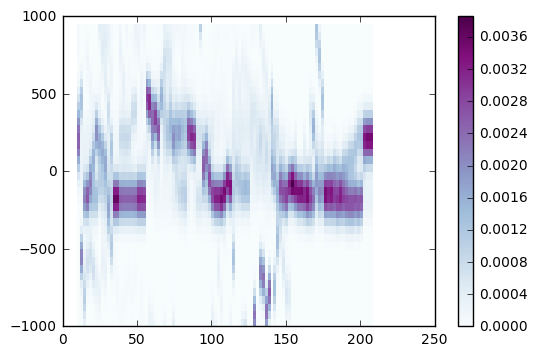

In [74]:
hlist = []
time_list = np.arange(10,210,2)

for time in time_list:
    bc,h = indicator_z_distribution(time,'delta')

    hlist.append(h)
    
#plt.plot(bc,hlist)
#plt.show()

plt.pcolormesh(time_list,bc,np.array(hlist).T,cmap=plt.cm.BuPu) #,vmin=0,vmax=0.4)
plt.colorbar()



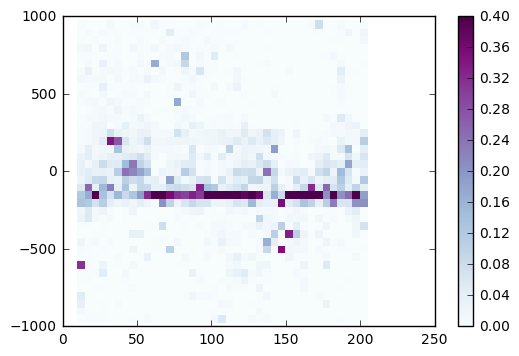

In [42]:
plt.pcolormesh(time_list,bc,np.array(hlist).T,cmap=plt.cm.BuPu,vmin=0,vmax=0.4)
plt.colorbar()